In [ ]:
NAME = "Junyu Zhu"

In [ ]:
#I use generated fake data instead to show/test the project since notebook lacks some module

In [2]:
import pandas as pd
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from scipy.stats import spearmanr
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /home/jz766/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jz766/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jz766/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jz766/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Section 1: Getting data(Not used here)

In [4]:
# Read posts data
posts_df = pd.read_csv('sample_posts.txt', sep='\t')
print("Posts Data:")
print(posts_df.head())

# Read survey data
survey_df = pd.read_csv('sample_survey.txt', sep='\t')
print("\nSurvey Data:")
print(survey_df.head())

Posts Data:
                    platform,text,created_at,user_id
0  Twitter,This is a sample post about topic one....
1  Twitter,This is a sample post about topic five...
2  Twitter,This is a sample post about topic thre...
3  Twitter,This is a sample post about topic five...
4  Twitter,This is a sample post about topic thre...

Survey Data:
  user_id,platform,civility_score,usability_score,echo_chamber_perception,intelligence
0   4099,Facebook,2.604736,2.848905,False,112.042156                                  
1    6671,Mastodon,1.940526,1.763059,True,115.675115                                  
2      6793,Bluesky,2.785224,3.522357,False,142.2198                                  
3    5896,Bluesky,2.374365,3.824484,False,111.656733                                  
4   6634,Facebook,3.759659,3.813134,False,140.671724                                  


In [5]:
# Section 1: Data Generation

In [6]:
# Generate Fake Data
def generate_fake_data(platform, num_samples):
    fake_data = []
    for _ in range(num_samples):
        fake_data.append({
            "platform": platform,
            "text": f"This is a sample post about {random.choice(['topic one', 'topic two', 'topic three', 'topic four', 'topic five'])}.",
            "created_at": pd.Timestamp.now() - pd.to_timedelta(random.randint(1, 1000), unit='h'),
            "user_id": random.randint(1000, 9999)
        })
    return pd.DataFrame(fake_data)

# Combine fake data from multiple platforms
def create_fake_dataset():
    platforms = ["Twitter", "Facebook", "Instagram", "Bluesky", "Mastodon"]
    data_frames = [generate_fake_data(platform, 100) for platform in platforms]
    return pd.concat(data_frames, ignore_index=True)


In [7]:
# Generate the dataset and print the first few rows
data = create_fake_dataset()
print("Generated Dataset (First 5 Rows):")
print(data.head())

Generated Dataset (First 5 Rows):
  platform                                      text  \
0  Twitter   This is a sample post about topic four.   
1  Twitter  This is a sample post about topic three.   
2  Twitter    This is a sample post about topic one.   
3  Twitter    This is a sample post about topic two.   
4  Twitter    This is a sample post about topic one.   

                  created_at  user_id  
0 2024-11-07 02:46:34.557412     5579  
1 2024-11-15 17:46:34.557655     7948  
2 2024-11-30 00:46:34.557702     9455  
3 2024-11-01 14:46:34.557734     5870  
4 2024-11-06 04:46:34.557762     8927  


In [8]:
# Generate Fake Survey Data
def generate_survey_data(num_responses=100):
    survey_data = []
    for _ in range(num_responses):
        response = {
            "user_id": random.randint(1000, 9999),
            "platform": random.choice(["Twitter", "Facebook", "Instagram", "Bluesky", "Mastodon"]),
            "civility_score": random.uniform(1, 5),
            "usability_score": random.uniform(1, 5),
            "echo_chamber_perception": random.choice([True, False]),
            "intelligence": random.uniform(80, 160)  # IQ-like metric
        }
        survey_data.append(response)
    return pd.DataFrame(survey_data)


In [9]:
# Generate the dataset and print the first few rows
survey_data = generate_survey_data()
print("Generated Dataset (First 5 Rows):")
print(survey_data.head())

Generated Dataset (First 5 Rows):
   user_id  platform  civility_score  usability_score  \
0     5063   Twitter        3.100002         1.122429   
1     4634   Twitter        1.343578         2.037000   
2     8901  Mastodon        3.478047         3.543304   
3     9491   Twitter        1.167504         3.798037   
4     5309  Mastodon        3.300131         4.001628   

   echo_chamber_perception  intelligence  
0                    False    159.401515  
1                    False    138.670552  
2                    False    135.851212  
3                     True    100.892009  
4                    False     97.881961  


In [10]:
# Section 2: Data Cleaning and Preprocessing

In [11]:
# Clean and preprocess text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|\#\w+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower()
    return text


In [12]:
def preprocess_text(text):
    stop_words = set(stopwords.words("english"))
    tokens = word_tokenize(text)
    return " ".join([word for word in tokens if word not in stop_words])


In [13]:
# Clean and preprocess the data
data["clean_text"] = data["text"].apply(clean_text).apply(preprocess_text)
print("\nCleaned and Preprocessed Text (First 5 Rows):")
print(data[["text", "clean_text"]].head())


Cleaned and Preprocessed Text (First 5 Rows):
                                       text               clean_text
0   This is a sample post about topic four.   sample post topic four
1  This is a sample post about topic three.  sample post topic three
2    This is a sample post about topic one.    sample post topic one
3    This is a sample post about topic two.    sample post topic two
4    This is a sample post about topic one.    sample post topic one


In [186]:
# Section 3: Sentiment Analysis(Show only Don't run)

In [55]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to compute civility and intelligence scores
def evaluate_via_vader(text):
    """
    Evaluate civility and intelligence using VADER sentiment scores.
    Civility Score: Based on positive and negative sentiment.
    Intelligence Score: Based on the absolute compound score.
    """
    sentiment = analyzer.polarity_scores(text)
    civility_score = max(0, min(5, sentiment["pos"] * 5 - sentiment["neg"] * 5))  # Scale civility between 0-5
    intelligence_score = max(0, min(5, abs(sentiment["compound"]) * 5))  # Scale intelligence between 0-5
    return civility_score, intelligence_score

# Apply the function to the clean_text column
data["civility_score"], data["intelligence_score"] = zip(
    *data["clean_text"].apply(evaluate_via_vader)
)

In [111]:
# Display a preview of the updated DataFrame
print("\nUpdated Data with Civility and Intelligence Scores (First 5 Rows):")
print(data[["clean_text", "civility_score", "intelligence_score"]].head())


Updated Data with Civility and Intelligence Scores (First 5 Rows):


KeyError: "['civility_score', 'intelligence_score'] not in index"

In [14]:
# Section 3: Sentiment Generation

In [15]:
# Define functions to generate fake civility and intelligence scores
def generate_fake_civility():
    """Generate a fake civility score between 1 and 5."""
    return round(random.uniform(1, 5), 2)

def generate_fake_intelligence():
    """Generate a fake intelligence score between 1 and 5."""
    return round(random.uniform(1, 5), 2)

# Apply the functions to generate scores
data["civility_score"] = data["clean_text"].apply(lambda x: generate_fake_civility())
data["intelligence_score"] = data["clean_text"].apply(lambda x: generate_fake_intelligence())


In [16]:
# Display a preview of the updated DataFrame
print("\nUpdated Data with Fake Civility and Intelligence Scores (First 5 Rows):")
print(data[["clean_text", "civility_score", "intelligence_score"]].head())


Updated Data with Fake Civility and Intelligence Scores (First 5 Rows):
                clean_text  civility_score  intelligence_score
0   sample post topic four            3.07                2.44
1  sample post topic three            2.34                2.28
2    sample post topic one            4.45                4.68
3    sample post topic two            4.69                4.08
4    sample post topic one            4.85                3.85


In [17]:
# Section 4: Clustering and Echo Chamber Detection

In [18]:
# Detect Echo Chambers/Clustering
def detect_echo_chambers(texts, num_clusters=3):
    #Detect echo chambers by clustering similar content.
    #Parameters:
    #- texts: List of text data to cluster.
    #- num_clusters: Number of clusters to form.
    #Returns:
    #- labels: Cluster labels for each text entry.
    
    # Step 1: Vectorize text using TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(texts)
    # Step 2: Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    return labels


In [19]:
# Apply clustering for echo chamber detection
data["cluster"] = detect_echo_chambers(data["clean_text"])
print("\nClustering Results (First 5 Rows):")
print(data[["clean_text", "cluster"]].head())



Clustering Results (First 5 Rows):
                clean_text  cluster
0   sample post topic four        0
1  sample post topic three        0
2    sample post topic one        0
3    sample post topic two        0
4    sample post topic one        0


/usr/lib/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


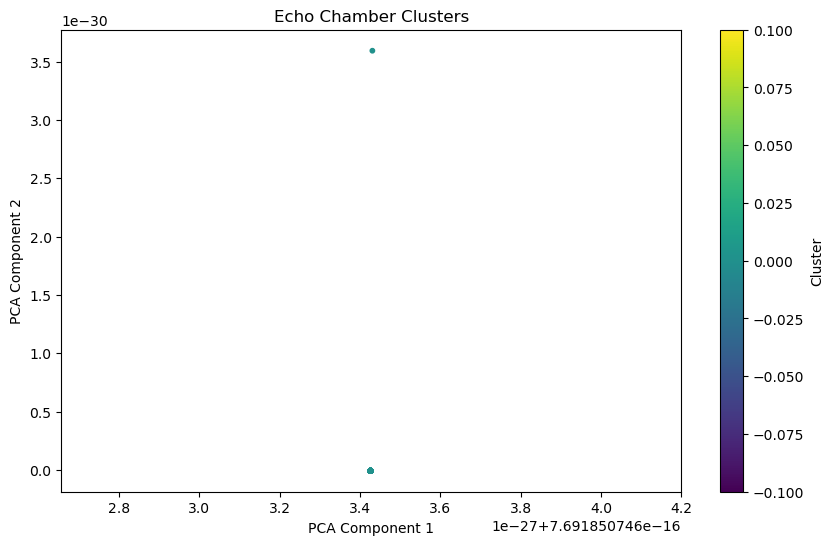

In [20]:
# Test: Visualize clusters (Dimensionality Reduction with PCA)
from sklearn.decomposition import PCA

def plot_clusters(data, texts, cluster_column):
    """
    Visualize the clustering results.

    Parameters:
    - data: DataFrame containing the data and cluster assignments.
    - texts: Original text data (used for dimensionality reduction).
    - cluster_column: Column name indicating cluster labels.
    """
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(texts)

    # Reduce dimensions for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X.toarray())

    plt.figure(figsize=(10, 6))
    plt.scatter(
        reduced_data[:, 0], 
        reduced_data[:, 1], 
        c=data[cluster_column], 
        cmap='viridis', 
        s=10
    )
    plt.colorbar(label="Cluster")
    plt.title("Echo Chamber Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Plot the clusters
plot_clusters(data, data["clean_text"], "cluster")

In [21]:
# Section 5: Algorithm Simulation

Total Recommendations: 50
Controversial Posts: 50
Frequency of Controversial Posts: 1.00


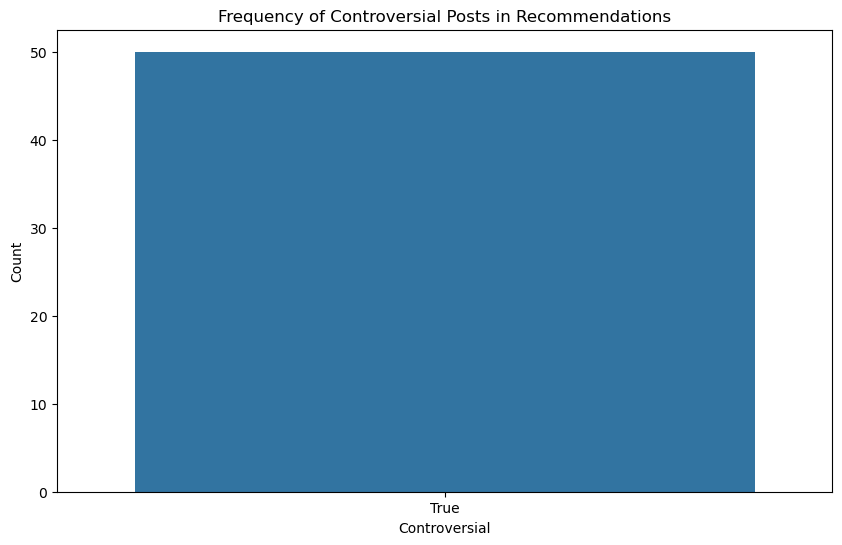

In [22]:
# Simulate content recommendation algorithms
# Define a function to simulate the recommendation algorithm
def simulate_recommendation_algorithm(data, num_recommendations=10):    
    #Simulate a recommendation algorithm by randomly selecting posts.
    return data.sample(num_recommendations)

# Define a function to determine if a post is controversial
def is_controversial(row, threshold=1.0):
    #Determine if a post is controversial based on the variance in civility scores.
    return row['civility_score'] > threshold

# Simulate the recommendation algorithm
recommended_posts = simulate_recommendation_algorithm(data, num_recommendations=50)

# Analyze the frequency of controversial posts in the recommendations
recommended_posts['controversial'] = recommended_posts.apply(is_controversial, axis=1)
controversial_count = recommended_posts['controversial'].sum()
total_recommendations = len(recommended_posts)

# Calculate the frequency of controversial posts
controversial_frequency = controversial_count / total_recommendations

# Display the results
print(f"Total Recommendations: {total_recommendations}")
print(f"Controversial Posts: {controversial_count}")
print(f"Frequency of Controversial Posts: {controversial_frequency:.2f}")

# Visualization of the results
plt.figure(figsize=(10, 6))
sns.countplot(x='controversial', data=recommended_posts)
plt.title('Frequency of Controversial Posts in Recommendations')
plt.xlabel('Controversial')
plt.ylabel('Count')
plt.show()

In [23]:
# Section 6: Database Integration

In [24]:
# Database setup
def setup_database():
    conn = sqlite3.connect("social_media_analysis.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS posts (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            platform TEXT,
            text TEXT,
            clean_text TEXT,
            created_at TEXT,
            user_id TEXT,
            civility_score REAL,
            intelligence_score REAL,
            cluster INTEGER
        )
    """)
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS survey (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_id TEXT,
            platform TEXT,
            civility_score REAL,
            usability_score REAL,
            echo_chamber_perception BOOLEAN,
            intelligence REAL
        )
    """)
    conn.commit()
    return conn


In [31]:
# Insert data into the database
def store_data(conn, dataframe, table_name):
    dataframe.to_sql(table_name, conn, if_exists="append", index=False)

# Setup database and insert generated data
conn = setup_database()
store_data(conn, data, "posts")
store_data(conn, survey_data, "survey")

# Verify the data insertion by querying the tables
cursor = conn.cursor()
cursor.execute("SELECT * FROM posts LIMIT 5")
print("Posts Table (First 5 Rows):")
for row in cursor.fetchall():
    print(row)

cursor.execute("SELECT * FROM survey LIMIT 5")
print("Survey Table (First 5 Rows):")
for row in cursor.fetchall():
    print(row)

# Close the connection
#conn.close()

Posts Table (First 5 Rows):
(1, 'Twitter', 'This is a sample post about topic one.', 'sample post topic one', '2024-10-31 22:12:30.053802', '1885', 2.4, 4.28, 0)
(2, 'Twitter', 'This is a sample post about topic five.', 'sample post topic five', '2024-11-28 10:12:30.054469', '9592', 1.49, 1.59, 0)
(3, 'Twitter', 'This is a sample post about topic three.', 'sample post topic three', '2024-11-12 21:12:30.054593', '5158', 1.28, 4.64, 0)
(4, 'Twitter', 'This is a sample post about topic five.', 'sample post topic five', '2024-11-29 20:12:30.054667', '6051', 1.8, 4.29, 0)
(5, 'Twitter', 'This is a sample post about topic three.', 'sample post topic three', '2024-12-11 21:12:30.054725', '8444', 2.95, 2.91, 0)
Survey Table (First 5 Rows):
(1, '4099', 'Facebook', 2.6047361037633574, 2.848905496201984, 0, 112.04215572839452)
(2, '6671', 'Mastodon', 1.9405260521451986, 1.7630588223362684, 1, 115.67511504253824)
(3, '6793', 'Bluesky', 2.7852238770692783, 3.5223568496733733, 0, 142.21979963986016)

In [26]:
# Section 7: Queries/Database(sql) manipulations

In [32]:
# Query execution
def run_query(query):
    conn = sqlite3.connect("social_media_analysis.db")
    cursor = conn.cursor()
    cursor.execute(query)
    results = cursor.fetchall()
    conn.close()
    return results


In [33]:
print("Analyzing relationships with SQL queries...")

query = """
SELECT 
    p.platform AS platform,
    p.cluster AS cluster,
    COUNT(p.id) AS post_count
FROM posts p
GROUP BY p.platform, p.cluster
ORDER BY platform, cluster;
"""
result = pd.read_sql_query(query, conn)
print("\nCluster Distribution Across Platforms:")
print(result)


Analyzing relationships with SQL queries...

Cluster Distribution Across Platforms:
    platform  cluster  post_count
0    Bluesky        0         300
1   Facebook        0         300
2  Instagram        0         300
3   Mastodon        0         300
4    Twitter        0         300


In [34]:
query = """
SELECT 
    p.platform AS platform,
    AVG(p.civility_score) AS avg_civility,
    AVG(p.intelligence_score) AS avg_intelligence
FROM posts p
GROUP BY p.platform
ORDER BY avg_civility DESC;
"""
result = pd.read_sql_query(query, conn)
print("\nRelationships Between Civility and Intelligence Levels by Platform:")
print(result)



Relationships Between Civility and Intelligence Levels by Platform:
    platform  avg_civility  avg_intelligence
0    Twitter      3.192733          3.107867
1    Bluesky      3.042667          2.899500
2   Facebook      2.980400          2.948300
3   Mastodon      2.939833          3.113067
4  Instagram      2.915133          3.019467


In [35]:
query = """
SELECT 
    p.cluster AS cluster,
    AVG(p.civility_score) AS avg_civility,
    AVG(p.intelligence_score) AS avg_intelligence,
    COUNT(p.id) AS post_count
FROM posts p
GROUP BY p.cluster
ORDER BY avg_civility DESC, avg_intelligence DESC;
"""
result = pd.read_sql_query(query, conn)
print("\nCivility and Intelligence Levels by Clusters:")
print(result)



Civility and Intelligence Levels by Clusters:
   cluster  avg_civility  avg_intelligence  post_count
0        0      3.014153           3.01764        1500


In [36]:
query = """
SELECT 
    p.id AS post_id,
    p.platform AS post_platform,
    p.text AS post_text,
    s.platform AS survey_platform,
    s.civility_score AS survey_civility,
    s.usability_score
FROM posts p
JOIN survey s ON p.user_id = s.user_id
LIMIT 10;
"""
result = pd.read_sql_query(query, conn)
print("\nPosts with Survey Data (First 10 Rows):")
print(result)



Posts with Survey Data (First 10 Rows):
   post_id post_platform                                 post_text  \
0       15       Twitter   This is a sample post about topic five.   
1       79       Twitter    This is a sample post about topic two.   
2       79       Twitter    This is a sample post about topic two.   
3      108      Facebook    This is a sample post about topic two.   
4      139      Facebook  This is a sample post about topic three.   
5      188      Facebook  This is a sample post about topic three.   
6      188      Facebook  This is a sample post about topic three.   
7      205     Instagram    This is a sample post about topic one.   
8      230     Instagram   This is a sample post about topic four.   
9      230     Instagram   This is a sample post about topic four.   

  survey_platform  survey_civility  usability_score  
0         Twitter         4.231372         4.754842  
1         Bluesky         3.899745         3.129905  
2         Bluesky         

In [37]:
query = """
SELECT 
    p.platform AS post_platform,
    AVG(p.civility_score) AS avg_post_civility,
    AVG(s.civility_score) AS avg_survey_civility
FROM posts p
JOIN survey s ON p.user_id = s.user_id
GROUP BY p.platform;
"""
result = pd.read_sql_query(query, conn)
print("\nAverage Civility by Platform:")
print(result)



Average Civility by Platform:
  post_platform  avg_post_civility  avg_survey_civility
0       Bluesky           3.270952             2.635334
1      Facebook           2.796250             3.640161
2     Instagram           4.029474             3.234882
3      Mastodon           2.779091             1.999489
4       Twitter           2.648000             3.402697


In [38]:
query = """
SELECT 
    AVG(s.usability_score) AS avg_usability,
    AVG(p.civility_score) AS avg_post_civility
FROM survey s
JOIN posts p ON s.user_id = p.user_id
GROUP BY s.platform;
"""
result = pd.read_sql_query(query, conn)
print("\nUsability vs. Civility by Platform:")
print(result)



Usability vs. Civility by Platform:
   avg_usability  avg_post_civility
0       2.617196           2.666667
1       3.125378           2.945000
2       1.942435           3.240000
3       3.209094           3.319091
4       2.795034           3.780909


In [39]:
query = """
SELECT 
    p.id AS post_id,
    p.civility_score AS post_civility,
    s.civility_score AS survey_civility,
    p.clean_text
FROM posts p
JOIN survey s ON p.user_id = s.user_id
WHERE p.civility_score < 2
ORDER BY p.civility_score ASC
LIMIT 10;
"""
result = pd.read_sql_query(query, conn)
print("\nComparison of Controversial Posts and Survey Civility (First 10 Rows):")
print(result)



Comparison of Controversial Posts and Survey Civility (First 10 Rows):
   post_id  post_civility  survey_civility               clean_text
0      332           1.43         2.785224    sample post topic one
1      380           1.60         2.202373   sample post topic five
2      380           1.60         2.202373   sample post topic five
3      139           1.79         2.925593  sample post topic three
4      771           1.99         2.141257    sample post topic two
5     1271           1.99         2.141257    sample post topic two


In [40]:
# close database
conn.close()

In [41]:
# Section 8: Visualization and Data Analysis

In [ ]:
# Civility Distribution
sns.histplot(data["civility_score"], bins=5, kde=False)
plt.title("Distribution of Civility Scores")
plt.xlabel("Civility Score")
plt.ylabel("Frequency")
plt.show()

# Intelligence vs Civility
sns.scatterplot(x="civility_score", y="intelligence_score", hue="cluster", data=data)
plt.title("Civility vs Intelligence by Cluster")
plt.xlabel("Civility Score")
plt.ylabel("Intelligence Score")
plt.legend(title="Cluster")
plt.show()


Cluster Distribution Across Platforms (Proportion):
    platform  cluster  count  proportion
0    Bluesky        0    100         1.0
1   Facebook        0    100         1.0
2  Instagram        0    100         1.0
3   Mastodon        0    100         1.0
4    Twitter        0    100         1.0


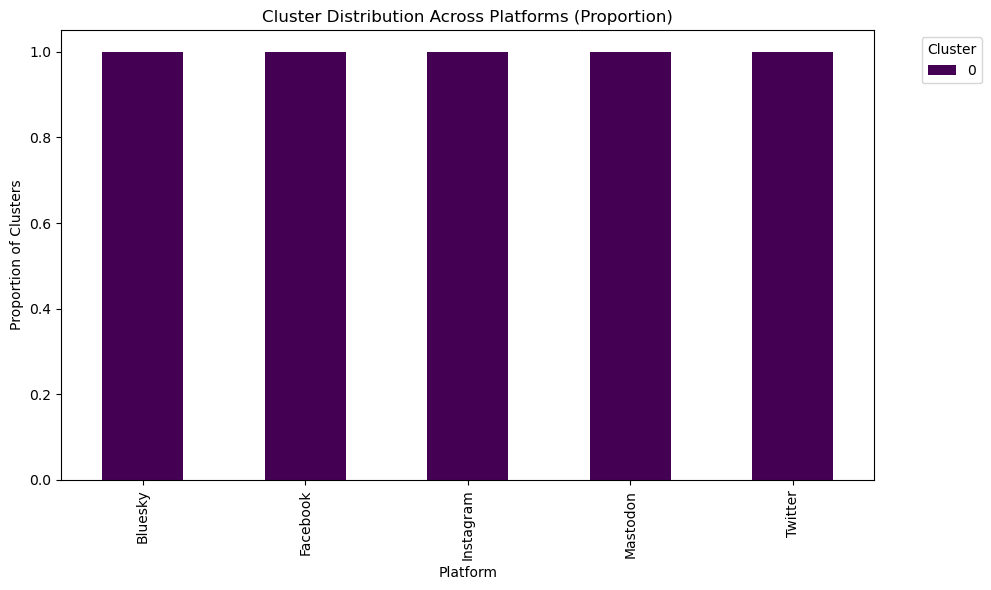

In [43]:
# Cluster Distribution Across Platforms
cluster_distribution = data.groupby(["platform", "cluster"]).size().reset_index(name="count")
total_counts = cluster_distribution.groupby("platform")["count"].transform("sum")
cluster_distribution["proportion"] = cluster_distribution["count"] / total_counts

print("\nCluster Distribution Across Platforms (Proportion):")
print(cluster_distribution)

# Visualization: Stacked Bar Chart for Cluster Distribution
platforms = cluster_distribution["platform"].unique()
clusters = cluster_distribution["cluster"].unique()
cluster_pivot = cluster_distribution.pivot(index="platform", columns="cluster", values="proportion").fillna(0)

cluster_pivot.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
plt.title("Cluster Distribution Across Platforms (Proportion)")
plt.xlabel("Platform")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Intelligence Scores Across Platforms:
    platform  intelligence_score
0    Bluesky              2.8057
1   Facebook              2.8876
2  Instagram              2.9386
3   Mastodon              3.2119
4    Twitter              3.2122


/tmp/ipykernel_3212241/2720078814.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="platform", y="intelligence_score", data=intelligence, palette="coolwarm")


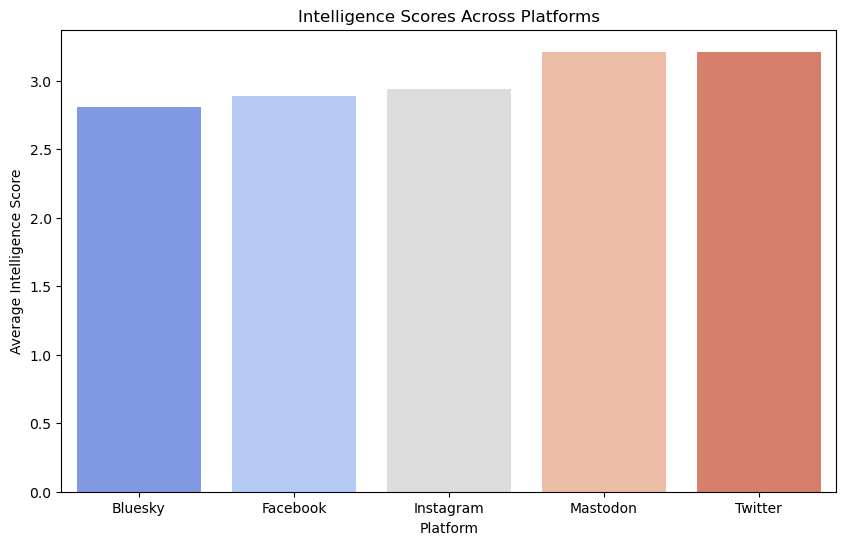

In [44]:
# Intelligence Scores Across Platforms
intelligence = data.groupby("platform")["intelligence_score"].mean().reset_index()
print("\nIntelligence Scores Across Platforms:")
print(intelligence)

# Visualization: Intelligence Scores
plt.figure(figsize=(10, 6))
sns.barplot(x="platform", y="intelligence_score", data=intelligence, palette="coolwarm")
plt.title("Intelligence Scores Across Platforms")
plt.xlabel("Platform")
plt.ylabel("Average Intelligence Score")
plt.show()

In [ ]:
import numpy as np
# Perception vs Reality (Civility and Intelligence)
# Aggregating actual scores from the posts
actual_scores = data.groupby("platform").agg({
    "civility_score": "mean",
    "intelligence_score": "mean"
}).reset_index()
actual_scores.columns = ["platform", "actual_civility_score", "actual_intelligence_score"]

# Aggregating survey scores
survey_scores = survey_data.groupby("platform").agg({
    "civility_score": "mean",
    "intelligence": "mean"
}).reset_index()
survey_scores.columns = ["platform", "perceived_civility_score", "perceived_intelligence_score"]

# Merge the two datasets for comparison
perception_vs_reality = pd.merge(actual_scores, survey_scores, on="platform")

print("\nPerception vs Reality of Civility and Intelligence Scores:")
print(perception_vs_reality)

# Visualization: Grouped Bar Chart for Perception vs Reality
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

x = np.arange(len(perception_vs_reality["platform"]))
width = 0.35  # Bar width

# Civility Comparison
ax[0].bar(x - width/2, perception_vs_reality["actual_civility_score"], width, label="Actual Civility Score", color="skyblue")
ax[0].bar(x + width/2, perception_vs_reality["perceived_civility_score"], width, label="Perceived Civility Score", color="orange")
ax[0].set_title("Perception vs Reality of Civility Scores Across Platforms")
ax[0].set_ylabel("Civility Score")
ax[0].set_xticks(x)
ax[0].set_xticklabels(perception_vs_reality["platform"])
ax[0].legend()

# Intelligence Comparison
ax[1].bar(x - width/2, perception_vs_reality["actual_intelligence_score"], width, label="Actual Intelligence Score", color="lightgreen")
ax[1].bar(x + width/2, perception_vs_reality["perceived_intelligence_score"], width, label="Perceived Intelligence Score", color="purple")
ax[1].set_title("Perception vs Reality of Intelligence Scores Across Platforms")
ax[1].set_ylabel("Intelligence Score")
ax[1].set_xticks(x)
ax[1].set_xticklabels(perception_vs_reality["platform"])
ax[1].legend()

plt.xlabel("Platform")
plt.tight_layout()
plt.show()


In [46]:
# Section 9: Machine Learning: Relationships and Analysis

In [47]:
# Civility and Intelligence
def analyze_relationships(data):
    # Use Linear Regression to analyze relationships.
    # Civility and Intelligence Relationship
    X = data[["civility_score"]]
    y = data["intelligence_score"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")
    return model

relationship_model = analyze_relationships(data)


Mean Squared Error: 1.30
R-squared: -0.06


In [48]:
# Algorithms and Echo chambers
# Preprocess data
def preprocess_data(data, survey_data):
    # Encode categorical variables
    le_platform = LabelEncoder()
    data['platform_encoded'] = le_platform.fit_transform(data['platform'])
    survey_data['platform_encoded'] = le_platform.transform(survey_data['platform'])
    
    # Merge data and survey_data on user_id
    merged_data = pd.merge(data, survey_data, on='user_id')
    
    return merged_data

# Analyze relationship between algorithms and echo chambers using linear regression
def analyze_relationships(data, survey_data):
    merged_data = preprocess_data(data, survey_data)
    
    # Features and target variable
    X = merged_data[['platform_encoded_x', 'cluster']]
    y = merged_data['echo_chamber_perception'].astype(int)  # Convert boolean to int for regression
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")
    
    return model

# Run the analysis
relationship_model = analyze_relationships(data, survey_data)

Mean Squared Error: 0.60
R-squared: nan


/usr/lib/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [49]:
# Summary
print("\nFinal Data Sample:")
print(data.head())
print(survey_data.head())


Final Data Sample:
  platform                                      text  \
0  Twitter   This is a sample post about topic four.   
1  Twitter  This is a sample post about topic three.   
2  Twitter    This is a sample post about topic one.   
3  Twitter    This is a sample post about topic two.   
4  Twitter    This is a sample post about topic one.   

                  created_at  user_id               clean_text  \
0 2024-11-07 02:46:34.557412     5579   sample post topic four   
1 2024-11-15 17:46:34.557655     7948  sample post topic three   
2 2024-11-30 00:46:34.557702     9455    sample post topic one   
3 2024-11-01 14:46:34.557734     5870    sample post topic two   
4 2024-11-06 04:46:34.557762     8927    sample post topic one   

   civility_score  intelligence_score  cluster  platform_encoded  
0            3.07                2.44        0                 4  
1            2.34                2.28        0                 4  
2            4.45                4.68        

In [ ]:
# Extra: Main Workflow